In [6]:
import numpy as np
from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from scipy.stats import entropy
from numpy.linalg import norm


In [18]:
import ot
from utils import simulate_dataset, format_dataset, simulate_dataset_UF
from repairs import DI_list_geometric_repair, DI_list_random_repair,DI_list_merge_repair
from sklearn.manifold import TSNE
from disparate import *

In [280]:

dark_blue = '#1f77b4' # darker blue
light_blue = '#aec7e8' # lighter blue

# Two shades of red
red1 = '#d62728' # darker red
red2 = '#ff9896' # lighter red

light_green = '#90EE90'
dark_green = '#006400'


In [8]:
def gmm_kl(gmm_p, gmm_q, n_samples=10**5):
    X = gmm_p.sample(n_samples)[0]
    log_p_X= gmm_p.score_samples(X)
    log_q_X= gmm_q.score_samples(X)
    return log_p_X.mean() - log_q_X.mean()

In [17]:

from scipy.spatial.distance import cdist
import numpy as np

def find_closest_pair(means, covariances):
    # Compute the distance matrix between all pairs of Gaussians
    dist_matrix = cdist(means, means, metric='mahalanobis', VI=covariances)

    # Set the diagonal elements to infinity, so that each Gaussian is not the closest to itself
    np.fill_diagonal(dist_matrix, np.inf)

    # Initialize the three closest pairs with the first three pairs of indices
    pair1, pair2, pair3 = [0, 1], [2, 3], [4, 5]
    
    # Initialize the closest distance with the distance between the first three pairs of Gaussians
    closest_dist = dist_matrix[pair1[0], pair1[1]] + dist_matrix[pair2[0], pair2[1]] + dist_matrix[pair3[0], pair3[1]]
    
    # Loop through all pairs of Gaussians to find the three closest pairs
    for i in range(len(means)):
        for j in range(i+1, len(means)):
            for k in range(len(means)):
                for l in range(k+1, len(means)):
                    for m in range(len(means)):
                        for n in range(m+1, len(means)):
                            # Check if the three pairs share any elements
                            if i not in [k, l, m, n] and j not in [k, l, m, n] and k not in [i, j, m, n] and l not in [i, j, m, n] and m not in [i, j, k, l] and n not in [i, j, k, l]:
                                # Compute the distance between the three pairs of Gaussians
                                dist = dist_matrix[i, j] + dist_matrix[k, l] + dist_matrix[m, n]
                                # If the distance is smaller than the current closest distance, update the closest pairs
                                if dist < closest_dist:
                                    closest_dist = dist
                                    pair1, pair2, pair3 = [i, j], [k, l], [m, n]
    
    # Return the three closest pairs
    return pair1, pair2, pair3


In [10]:
def merge(mu, mu2, cov , cov2, weights):
    # merge two Gaussian
    # Input:
    # mu, mu2: means of the two Gaussians
    # cov, cov2: covariance matrices of the two Gaussians
    # weights: weights of the two Gaussians
    # Output:
    # mu_m: mean of the merged Gaussian
    # cov_m: covariance matrix of the merged Gaussian
    # weight_m: weight of the merged Gaussian
    # Reference: https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Merging_of_normal_distributions
    # Written by Mo Chen (

    alpha = (weights[0])**2/(weights[0]+weights[1])**2
    #alpha = (weights[0])/(weights[0]+weights[1])

    mu_m = (weights[0]*mu + weights[1]*mu2)/(weights[0]+weights[1])
    #cov_m = (weights[0]*cov + weights[1]*cov2 + weights[0]*weights[1]/(weights[0]+weights[1])*(mu-mu2).dot((mu-mu2).T))/(weights[0]+weights[1])
    cov_m  = alpha*cov + (1-alpha)*cov2
    weight_m = weights[0]+weights[1]

    return mu_m, cov_m, weight_m

In [26]:
def sample_guassian_UF(mu, mu2, mu3, mu4, mu5, mu6, cov, cov2, cov3, cov4, cov5, cov6, n, prob, d):
    # Compute the Decomposition:
    A = np.linalg.cholesky(cov)
    A2 = np.linalg.cholesky(cov2)
    A3 = np.linalg.cholesky(cov3)
    A4 = np.linalg.cholesky(cov4)
    A5 = np.linalg.cholesky(cov5)
    A6 = np.linalg.cholesky(cov6)

    X = np.zeros((d+2,n))
    
    for i in range(n):
        r = np.random.rand() 
        if r <= prob[0]:
            Z = np.random.normal(size=(d, 1))
            x= np.dot(A,Z) + + np.reshape(mu, (2,1))
     
            #replace the i-th row of X with x
            X[0,i] = x[0]
            X[1,i] = x[1]
            #mixing label
            X[2,i] = 0
            #protected label
            X[3,i] = 0
 
            #add a 0 to the end of each sample
        elif  prob[0] <= r <= prob[0] + prob[1]:
            Z = np.random.normal(size=(d, 1))
            x= np.dot(A2,Z) + + np.reshape(mu2, (2,1))
        
            X[0,i] = x[0]
            X[1,i] = x[1]
            X[2,i] = 0
            #protected label
            X[3,i] = 1

        elif  prob[0] + prob[1] <= r <= prob[0] + prob[1] + prob[2]:
            Z = np.random.normal(size=(d, 1))
            x= np.dot(A3,Z) + + np.reshape(mu3, (2,1))
            X[0,i] = x[0]
            X[1,i] = x[1]
            #true label
            X[2,i] = 1
            #protected label
            X[3,i] = 0
        elif prob[0] + prob[1] + prob[2] <= r <= prob[0] + prob[1] + prob[2] + prob[3]:
            Z = np.random.normal(size=(d, 1))
            x= np.dot(A4,Z) + + np.reshape(mu4, (2,1))
            X[0,i] = x[0]
            X[1,i] = x[1]
            #true label
            X[2,i] = 1
            #protected label
            X[3,i] = 1
        elif prob[0] + prob[1] + prob[2] + prob[3] <= r <= prob[0] + prob[1] + prob[2] + prob[3] + prob[4]:

            Z = np.random.normal(size=(d, 1))
            x= np.dot(A5,Z) + + np.reshape(mu5, (2,1))
            X[0,i] = x[0]
            X[1,i] = x[1]
            #true label
            X[2,i] = 2
            #protected label
            X[3,i] = 0
        else:
            Z = np.random.normal(size=(d, 1))
            x= np.dot(A6,Z) + + np.reshape(mu6, (2,1))
            X[0,i] = x[0]
            X[1,i] = x[1]
            #true label
            X[2,i] = 2
            #protected label
            X[3,i] = 1
        
    return X

In [28]:
def sample_guassian_F(mu, mu2, mu3, mu4, mu5, mu6, cov, cov2, cov3, cov4, cov5, cov6, n, prob, d): 

    means = np.array([mu,mu2, mu3, mu4, mu5, mu6])
    # print('means',means)
    covariances = np.array([cov, cov2, cov3, cov4,  cov5, cov6])
    weights = np.array([prob[0], prob[1], prob[2], prob[3], prob[4], prob[5]])

    #first find closest pairs using malanobis distance
    closest_pairs = find_closest_pair(means, covariances)
    print ('closest pairs ' , closest_pairs)
    # print('closest pair 1 ' , means[closest_pairs[0][0]], means[closest_pairs[0][1]])
    # print('closest pair 2 ' , means[closest_pairs[1][0]], means[closest_pairs[1][1]])

    # print(weights[closest_pairs[0]])

    
    # print ('closest pair 1 cov ')
    # print ( covariances[closest_pairs[0][0]])
    # print ( covariances[closest_pairs[0][1]])
    # print ('closest pair 2 cov ')
    # print ( covariances[closest_pairs[1][0]])
    # print ( covariances[closest_pairs[1][1]])
   


    #then merge the two closest pairs using the merge function
    mu_m, cov_m, weight_m = merge(means[closest_pairs[0][0]], means[closest_pairs[0][1]], covariances[closest_pairs[0][0]], covariances[closest_pairs[0][1]], weights[closest_pairs[0]])
    mu_m2, cov_m2, weight_m2 = merge(means[closest_pairs[1][0]], means[closest_pairs[1][1]], covariances[closest_pairs[1][1]], covariances[closest_pairs[1][0]], weights[closest_pairs[1]])
    mu_m3, cov_m3, weight_m3 = merge(means[closest_pairs[2][0]], means[closest_pairs[2][1]], covariances[closest_pairs[2][1]], covariances[closest_pairs[2][0]], weights[closest_pairs[2]])

    print('weight_m',weight_m)
    print('weight_m2',weight_m2)
    print('weight_m3',weight_m3)

  
    #now sample from the new mixture

    # Compute the Decomposition:
    A = np.linalg.cholesky(cov_m)
    A2 = np.linalg.cholesky(cov_m2)
    A3 = np.linalg.cholesky(cov_m3)



    X = np.zeros((d+1,n))

    for i in range(n):
        r = np.random.rand() 
        if r <= weight_m:
            Z = np.random.normal(size=(d, 1))
            x= np.dot(A,Z) + + np.reshape(mu_m, (2,1))
            X[0,i] = x[0]
            X[1,i] = x[1]
            X[2,i] = 0 
        elif weight_m <= r <= weight_m + weight_m2:
            Z = np.random.normal(size=(d, 1))
            x= np.dot(A2,Z) + + np.reshape(mu_m2, (2,1))
            X[0,i] = x[0]
            X[1,i] = x[1]
            X[2,i] = 1
        else:
            Z = np.random.normal(size=(d, 1))
            x= np.dot(A3,Z) + + np.reshape(mu_m3, (2,1))
            X[0,i] = x[0]
            X[1,i] = x[1]
            X[2,i] = 2
    return X

    # return X  

In [239]:
def f_cov(var_x, var_y, corr): 
    return np.matrix([[var_x, corr * np.sqrt(var_x * var_y)], [corr * np.sqrt(var_x * var_y), var_y]])

In [296]:
def plot_fair_vs_unfair(X_UF, y_Ap, y_Au,  X_F, y_F): 
    
    dark_blue = '#1f77b4' # darker blue
    light_blue = '#aec7e8' # lighter blue

    # Two shades of red
    dark_red = '#d62728' # darker red
    light_red = '#ff9896' # lighter red

    light_green = '#90EE90'
    dark_green = '#006400'


    

    #plot the results
    
    plt.subplot(1, 2, 1)
    plt.scatter(X_UF[0, (y_Au == 0) & (y_Ap == 0)], X_UF[1, (y_Au == 0) & (y_Ap == 0)],  c= light_red, label=r'($A_u$, $A_p$) = (0,0)', alpha=0.7)
    plt.scatter(X_UF[0, (y_Au == 0) & (y_Ap == 1)], X_UF[1, (y_Au == 0) & (y_Ap == 1)],  c= dark_red , label=r'($A_u$, $A_p$) = (0,1)',alpha=0.7)
    plt.scatter(X_UF[0, (y_Au == 1) & (y_Ap == 0)], X_UF[1, (y_Au == 1) & (y_Ap == 0)],  c= light_blue  , label=r'($A_u$, $A_p$) = (1,0)',alpha=0.7)
    plt.scatter(X_UF[0, (y_Au == 1) & (y_Ap == 1)], X_UF[1, (y_Au == 1) & (y_Ap == 1)],  c=  dark_blue  , label=r'($A_u$, $A_p$) = (1,1)',alpha=0.7)
    plt.scatter(X_UF[0, (y_Au == 2) & (y_Ap == 0)], X_UF[1, (y_Au == 2) & (y_Ap == 0)],  c=  light_green , label=r'($A_u$, $A_p$) = (2,0)',alpha=0.7)
    plt.scatter(X_UF[0, (y_Au == 2) & (y_Ap == 1)], X_UF[1, (y_Au == 2) & (y_Ap == 1)],  c=  dark_green , label=r'($A_u$, $A_p$) = (2,1)',alpha=0.7)

    # #plot midpoint 
    # plt.plot(0, 0,  c= 'black' , marker='o', markersize=10)
    # plt.plot(3, 3,  c= 'black' ,marker='o', markersize=10)
    # plt.plot(6, 6,  c= 'black' ,marker='o', markersize=10)



    
  
    plt.ylabel('x2',fontsize=15)
    plt.xlabel('x1',fontsize=15)
    # plt.xlim(-4, 8)
    # plt.ylim(-4, 8)

    plt.legend( fontsize=15)



    plt.title('Unfair Mixture Sampling: '  ,fontsize=15)
    plt.subplot(1, 2, 2)
    plt.scatter(X_F[0, y_F == 0], X_F[1, y_F == 0], c= 'red', label=r'($A_u$) = (0)',alpha=0.7)
    plt.scatter(X_F[0, y_F == 1], X_F[1, y_F == 1], c= 'blue', label=r'($A_u$) = (1)',alpha=0.7)
    plt.scatter(X_F[0, y_F == 2], X_F[1, y_F == 2], c= 'green', label=r'($A_u$) = (2)',alpha=0.7)

    plt.ylabel('x2',fontsize=15)
    plt.xlabel('x1',fontsize=15)
    plt.legend( fontsize=15)
    plt.title('Fair Mixture Sampling: ',fontsize=15)
    # plt.xlim(-4, 8)
    # plt.ylim(-4, 8)
    plt.show()


In [30]:
def JSD(P, Q):
    _P = P / norm(P, ord=1)
    _Q = Q / norm(Q, ord=1)
    _M = 0.5 * (_P + _Q)
    return 0.5 * (entropy(_P, _M) + entropy(_Q, _M))

In [171]:
def KLD(P, Q, epsilon): 
    # a small positive constant
    _P = (P + epsilon) / np.linalg.norm(P + epsilon, ord=1) 
    _Q = (Q + epsilon) / np.linalg.norm(Q + epsilon, ord=1) 
    return entropy(_P, _Q)

In [32]:
def DI(T_GMM):
    eps = 1e-8
    Y1_Ap0 = T_GMM[0,0] + T_GMM[0,2]
    Y1_Ap1 = T_GMM[0,1] + T_GMM[0,3]
    Y0_Ap0 = T_GMM[1,0] + T_GMM[1,2]
    Y0_Ap1 = T_GMM[1,1] + T_GMM[1,3]
 
 

    pr_Y1_Ap0  = Y1_Ap0 / (Y1_Ap0 + Y0_Ap0)
    pr_Y1_Ap1  = Y1_Ap1/ (Y1_Ap1 + Y0_Ap1)

    if pr_Y1_Ap0 == 0:
        pr_Y1_Ap0 = eps
    if pr_Y1_Ap1 == 0:
        pr_Y1_Ap1 = eps
 
    DI1  = pr_Y1_Ap0/(pr_Y1_Ap1 + eps) 
    DI2  = pr_Y1_Ap1/(pr_Y1_Ap0 + eps)

    if DI1 == 0 and  DI1 == 0:
        DI = 1
    elif DI1> DI2:
        DI = DI2
    else:
        DI = DI1
    return DI

closest pairs  ([0, 1], [2, 3], [4, 5])
weight_m 0.3333333333333333
weight_m2 0.3333333333333333
weight_m3 0.3333333333333333


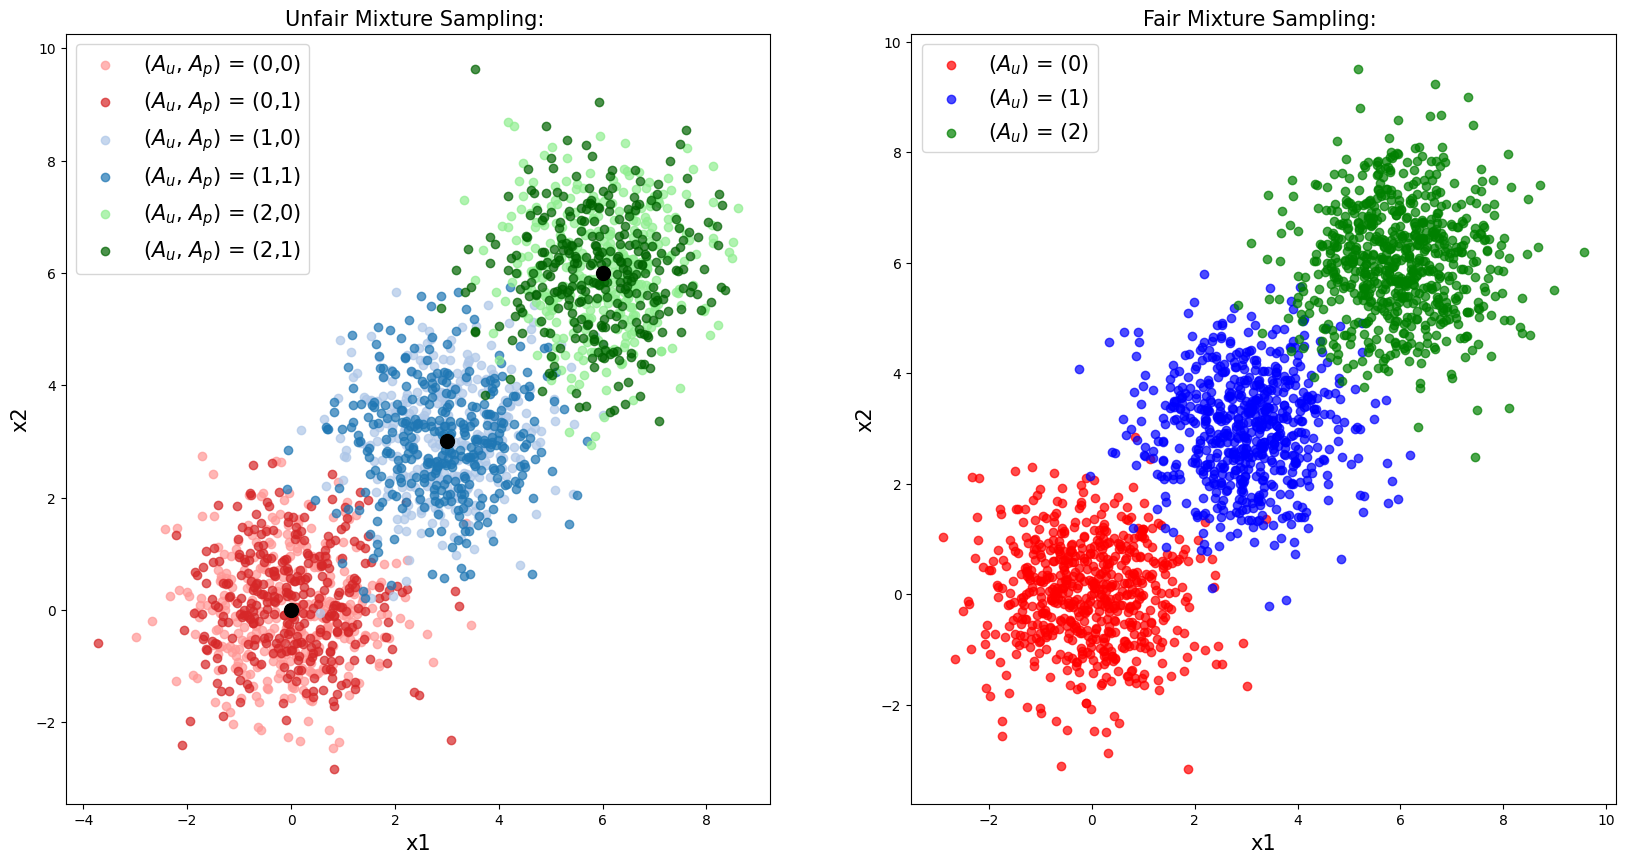

In [273]:

from sklearn.metrics import accuracy_score
from sklearn.metrics import adjusted_rand_score

mu  = [0, 0]
mu2 = [0, 0]
mu3 = [3, 3]
mu4 = [3, 3]
mu5 = [6, 6]
mu6 = [6, 6]


cov  = [[1, 0], 
        [0, 1]]
cov2 = [[1, 0],
        [0, 1]]
cov3 = [[1, 0],
        [0, 1]]
cov4 =  [[1, 0],
        [0, 1]]
cov5 =  [[1, 0],
        [0, 1]] 
cov6 =  [[1, 0],
        [0, 1]]



#Pr[Ap ] = 0.6
prob_p = [0.5, 0.5]
#Pr[Au | Ap=0 ]
p_u1  = [ 1/3, 1/3, 1/3]
#Pr[Au | Ap=1 ]
p_u2  = [ 1/3, 1/3, 1/3]	
	

prob = [p_u1[0]*prob_p[0], p_u1[1]*prob_p[0], p_u1[2]*prob_p[0], p_u2[0]*prob_p[1], p_u2[1]*prob_p[1], p_u2[2]*prob_p[1]]
n = 2000
d = 2




X_UF = sample_guassian_UF(mu, mu2, mu3, mu4, mu5, mu6, cov, cov2, cov3, cov4, cov5, cov6, n, prob, d)
y_Ap = X_UF[3,:]
y_Au = X_UF[2,:]


#sample from the fair mixture
X_F = sample_guassian_F(mu, mu2, mu3, mu4, mu5, mu6, cov, cov2, cov3, cov4, cov5, cov6, n, prob, d)
y_A = X_F[2,:]

fig = plt.figure(figsize=(20, 10))
plot_fair_vs_unfair(X_UF, y_Ap, y_Au,  X_F, y_A)
plt.show()

#fair clustering





In [223]:
import itertools
import numpy as np
from sklearn.metrics import accuracy_score, adjusted_rand_score
from sklearn.mixture import GaussianMixture

def fair_clustering(X_F,y_A ):
    
    X_F  = X_F[:,0:2]
    X_train, X_test, y_train, y_test = train_test_split(X_F, y_A, test_size=0.3, random_state=42)


    n_com = np.unique(y_A).shape[0]
    
    gmm = GaussianMixture(n_components=n_com, covariance_type='full', random_state=0).fit(X_train)
    labels_gmm = gmm.predict(X_test)


    #accuracy
    ari = adjusted_rand_score(y_test, labels_gmm)

    # Define all possible mappings of the labels
    label_permutations = itertools.permutations([0, 1, 2])

    # Loop over all possible mappings and find the one closest to the ARI
    min_difference = np.inf
    for perm in label_permutations:
        mapped_labels = np.array([perm[label] for label in labels_gmm])
        accuracy = accuracy_score(y_test, mapped_labels)
        difference = abs(ari - accuracy)
        if difference < min_difference:
            min_difference = difference
            best_mapping = perm
            best_accuracy = accuracy

    # Apply the best mapping to the labels
    labels_gmm = np.array([best_mapping[label] for label in labels_gmm])



    M = np.zeros((n_com,n_com))
    # labels_gmm = label_check(y_test, y_Ap, labels_gmm)


    for j in range(n_com):
        for i in range(n_com):
            M[i,j] = X_test[(y_test == i) & (labels_gmm == j), 1].shape[0]

    N = np.repeat(M, 2, axis=1)
   
    N = N/N.sum(axis=0)
    # print (N)

    #plot X_test and labels_gmm
    fig = plt.figure(figsize=(8, 8))

    colors = [blue1, blue2]
    
    # for i in range(2):
    #     plt.scatter(X_test[labels_gmm==i, 0], X_test[labels_gmm==i, 1], label=r'$\hat{Y}$ ='+str(i), color=colors[i], alpha=0.5)
    # plt.legend()
    # plt.xlabel('x1')
    # plt.ylabel('x2')
    # plt.show()

    return N, labels_gmm, y_test

In [36]:
def label_check(y_Au, y_Ap, y_pred):
  #jaccard_score
  # print ('-----------')
  JS1 = accuracy_score(y_Au, y_pred)
  ARI_1 = adjusted_rand_score(y_Au, y_pred)

  # print ('accuracy jaccard score', JS1, 'ari score', ARI_1) 

  # label flip
  y_gmm_flip = 1 - y_pred
  # print ('----flip----')
  JS2 = accuracy_score(y_Au, y_gmm_flip)
  # ARI_2 = adjusted_rand_score(y_test, y_gmm_flip)
  # print ('accuracy jaccard score', JS2, 'ari score', ARI_2  )
  # print ('-----------')

  #distance 
  dist1 = (JS1-ARI_1)**2
  dist2 = (JS2-ARI_1)**2

  if dist2 < dist1:
    y_pred = y_gmm_flip

  return y_pred

In [226]:
def KLD_(Ms, N, prob):

    prob1 = np.array(prob)
    epsilon = 1e-10
    #check for flip
    M = Ms
    M_p = M*prob1.T
    N_p = N*prob1.T


    epsilon = 1e-10

    kld = KLD(M_p, N_p, epsilon)

 

  

  
  

    return kld

In [38]:
def DI(XY):
    count_4_5 = np.sum((XY[:, 3] == 1) & (XY[:, 4] == 1))
    count_4_6 = np.sum((XY[:, 3] == 0) & (XY[:, 4] == 1))

    a = count_4_5/count_4_6
    b = count_4_6/count_4_5

    if a > b:
        di = b
    else:
        di = a

    return di
    

In [229]:
def unfair_clustering(X_UF,y_Au, y_Ap):

    #split the data into train and test
    X  = X_UF[:,0:2]
    Y = np.concatenate((y_Au.reshape(-1,1), y_Ap.reshape(-1,1)), axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
    y_test_1 = y_test[:,0]
    y_test_2 = y_test[:,1]
    
    
    num_com = np.unique(y_Au).shape[0]
    gmm = GaussianMixture(n_components=num_com, covariance_type='full', random_state=0).fit(X_train)
    labels_gmm = gmm.predict(X_test)

    print(X_test.shape)

    #accuracy
    ari = adjusted_rand_score(y_test_1, labels_gmm)

    # Define all possible mappings of the labels
    label_permutations = itertools.permutations([0, 1, 2])

    # Loop over all possible mappings and find the one closest to the ARI
    min_difference = np.inf
    for perm in label_permutations:
        mapped_labels = np.array([perm[label] for label in labels_gmm])
        accuracy = accuracy_score(y_test_1, mapped_labels)
        difference = abs(ari - accuracy)
        if difference < min_difference:
            min_difference = difference
            best_mapping = perm
            best_accuracy = accuracy

    # Apply the best mapping to the labels
    labels_gmm = np.array([best_mapping[label] for label in labels_gmm])



    
    #we need to see the result of the cluster and the protected attribute
    XY = np.concatenate((X_test[:,0].reshape(-1,1), X_test[:,1].reshape(-1,1), y_test_1.reshape(-1,1), y_test_2.reshape(-1,1), labels_gmm.reshape(-1,1)), axis=1)
    
    di = DI(XY)



    y_Au = XY[:, 2] 
    y_Ap = XY[:, 3]
    y_pred = XY[:, 4]
    print(np.unique(y_Au), np.unique(y_Ap), np.unique(y_pred))

    
    # y_pred = label_check(y_Au, y_Ap, y_pred)

    
    M = np.zeros((num_com, num_com*2))
    print(M)
   
    count = 0
    for i in range(num_com):
        for j in range(num_com):
            # print('i:',i, 'j:', j)
            count_Ap_0 = ((y_Au == i) & (y_Ap == 0) & (y_pred == j)).sum()
            count_Ap_1 = ((y_Au == i) & (y_Ap == 1) & (y_pred == j)).sum()
            # print('i:',i, 'j:', j, 'count Ap0', count_Ap_0, 'count Ap1',count_Ap_1)
            M[i, 2*j] = count_Ap_0
            M[i, 2*j+1] = count_Ap_1
            count += count_Ap_0 + count_Ap_1
    print ('count',count)
    #normalize the matrix
    M = M/M.sum(axis=0)
  
    return di, M

In [297]:

n = 1000
X_F = sample_guassian_F(mu, mu2, mu3, mu4, mu5, mu6, cov, cov2, cov3, cov4, cov5, cov6, n, prob, d)
y_A = X_F[2,:]

X_UF = sample_guassian_UF(mu, mu2, mu3, mu4, mu5, mu6, cov, cov2, cov3, cov4, cov5, cov6, n, prob, d)
y_Ap= X_UF[3,:]
y_Au = X_UF[2,:]


#fair clustering

X0 = X_UF[:,y_Ap==0]
X1 = X_UF[:,y_Ap==1]


Y0= X0[2:4,:].T
Y1= X1[2:4,:].T

X0 = X0[0:2,:].T
X1 = X1[0:2,:].T
iter = 10
N, labels_gmm, y_test = fair_clustering(X_F.T, y_A)

#unfair clustering
di, M = unfair_clustering(X_UF.T, y_Au, y_Ap)

print (di)
print (M)
print (N)

eps = 1e-10

print(np.sum(KLD_(M, N, eps)))


closest pairs  ([0, 2], [1, 4], [3, 5])
weight_m 0.3333333333333333
weight_m2 0.3333333333333333
weight_m3 0.3333333333333333
(200, 2)
[0. 1. 2.] [0. 1.] [0. 1. 2.]
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
count 200
0.25
[[0.         0.         0.46666667 1.         0.         0.77777778]
 [0.         0.44444444 0.53333333 0.         0.25       0.16666667]
 [1.         0.55555556 0.         0.         0.75       0.05555556]]
[[0.95575221 0.95575221 0.07058824 0.07058824 0.         0.        ]
 [0.04424779 0.04424779 0.88235294 0.88235294 0.05882353 0.05882353]
 [0.         0.         0.04705882 0.04705882 0.94117647 0.94117647]]
0.5872435859120375


<Figure size 800x800 with 0 Axes>

0.0
closest pairs  ([0, 1], [2, 3], [4, 5])
weight_m 0.3333333333333333
weight_m2 0.3333333333333333
weight_m3 0.3333333333333333


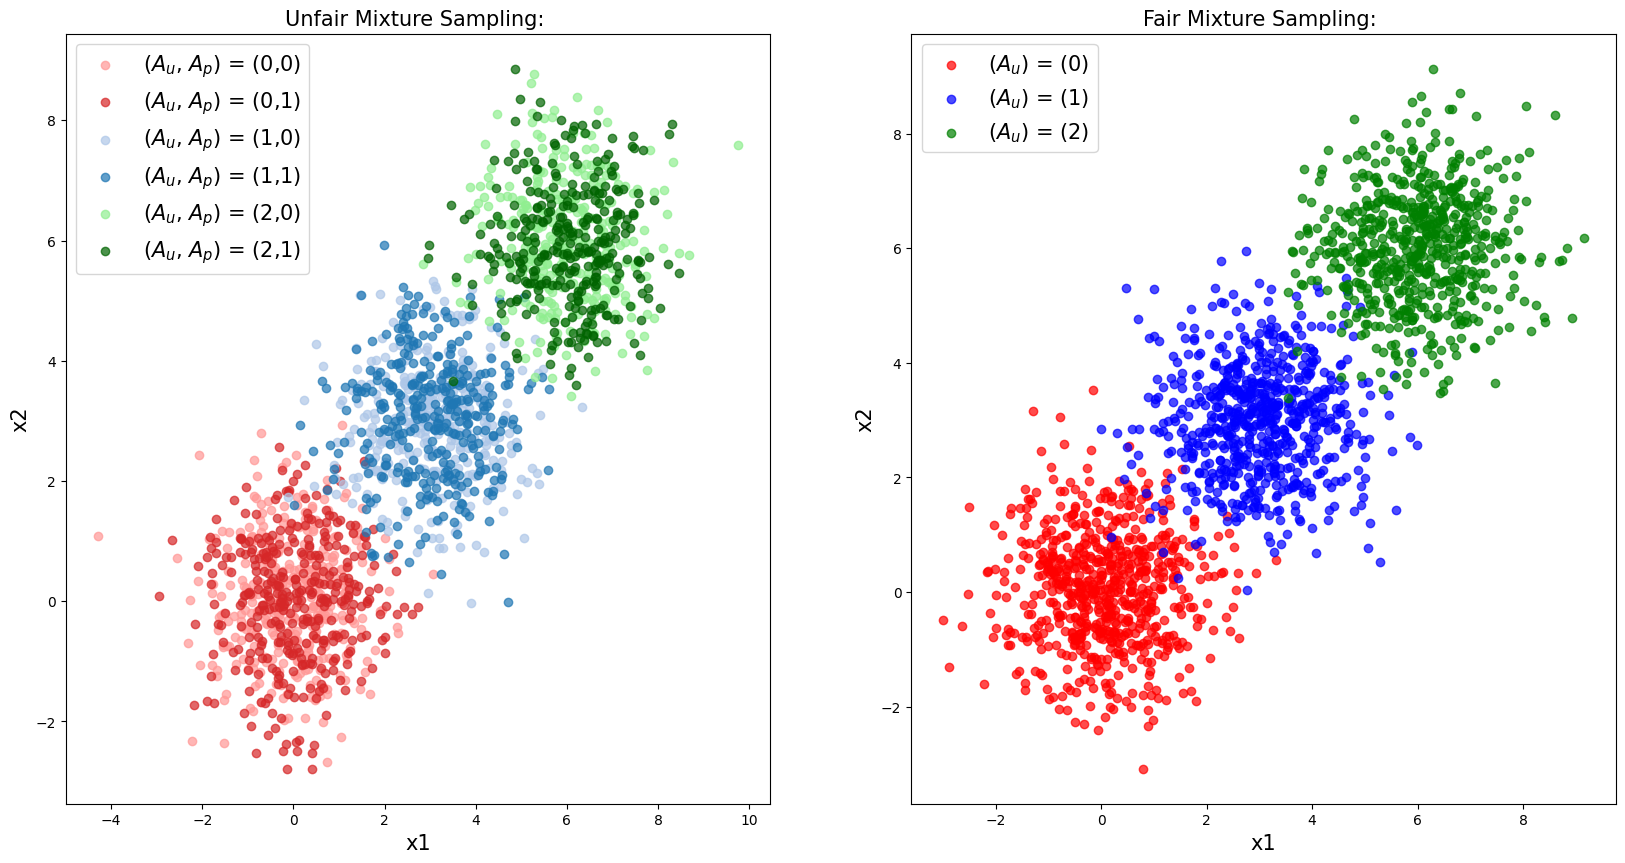

(400, 2)
[0. 1. 2.] [0. 1.] [0. 1. 2.]
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
count 400
0.22
closest pairs  ([0, 1], [4, 5], [2, 3])
weight_m 0.3333333333333333
weight_m2 0.3333333333333333
weight_m3 0.3333333333333333


<Figure size 800x800 with 0 Axes>

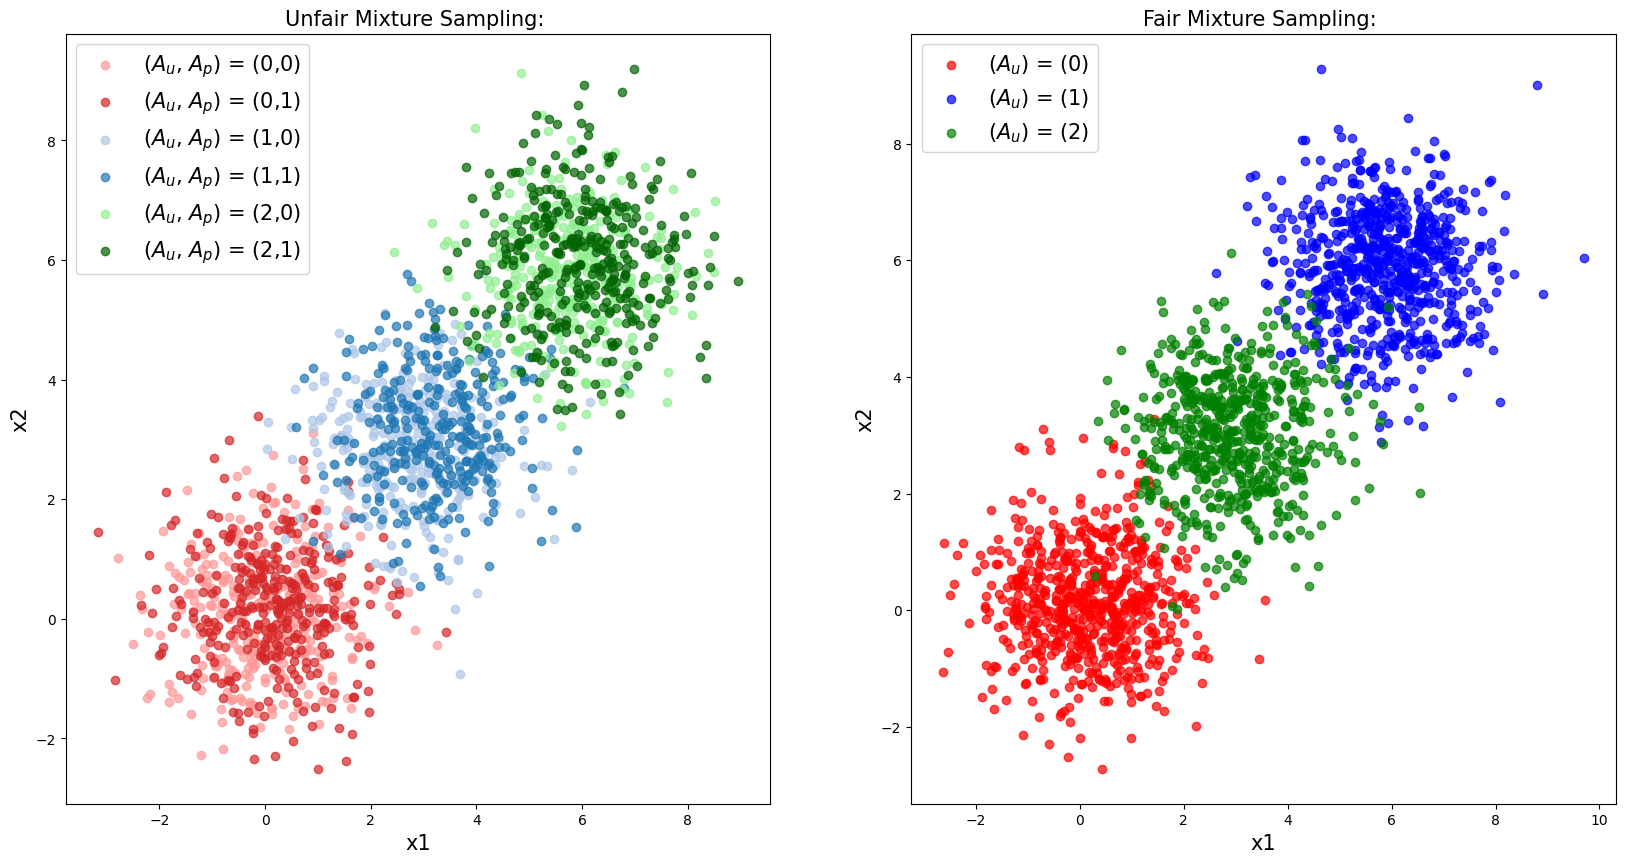

(400, 2)
[0. 1. 2.] [0. 1.] [0. 1. 2.]
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
count 400
0.44
closest pairs  ([0, 1], [4, 5], [2, 3])
weight_m 0.3333333333333333
weight_m2 0.3333333333333333
weight_m3 0.3333333333333333


<Figure size 800x800 with 0 Axes>

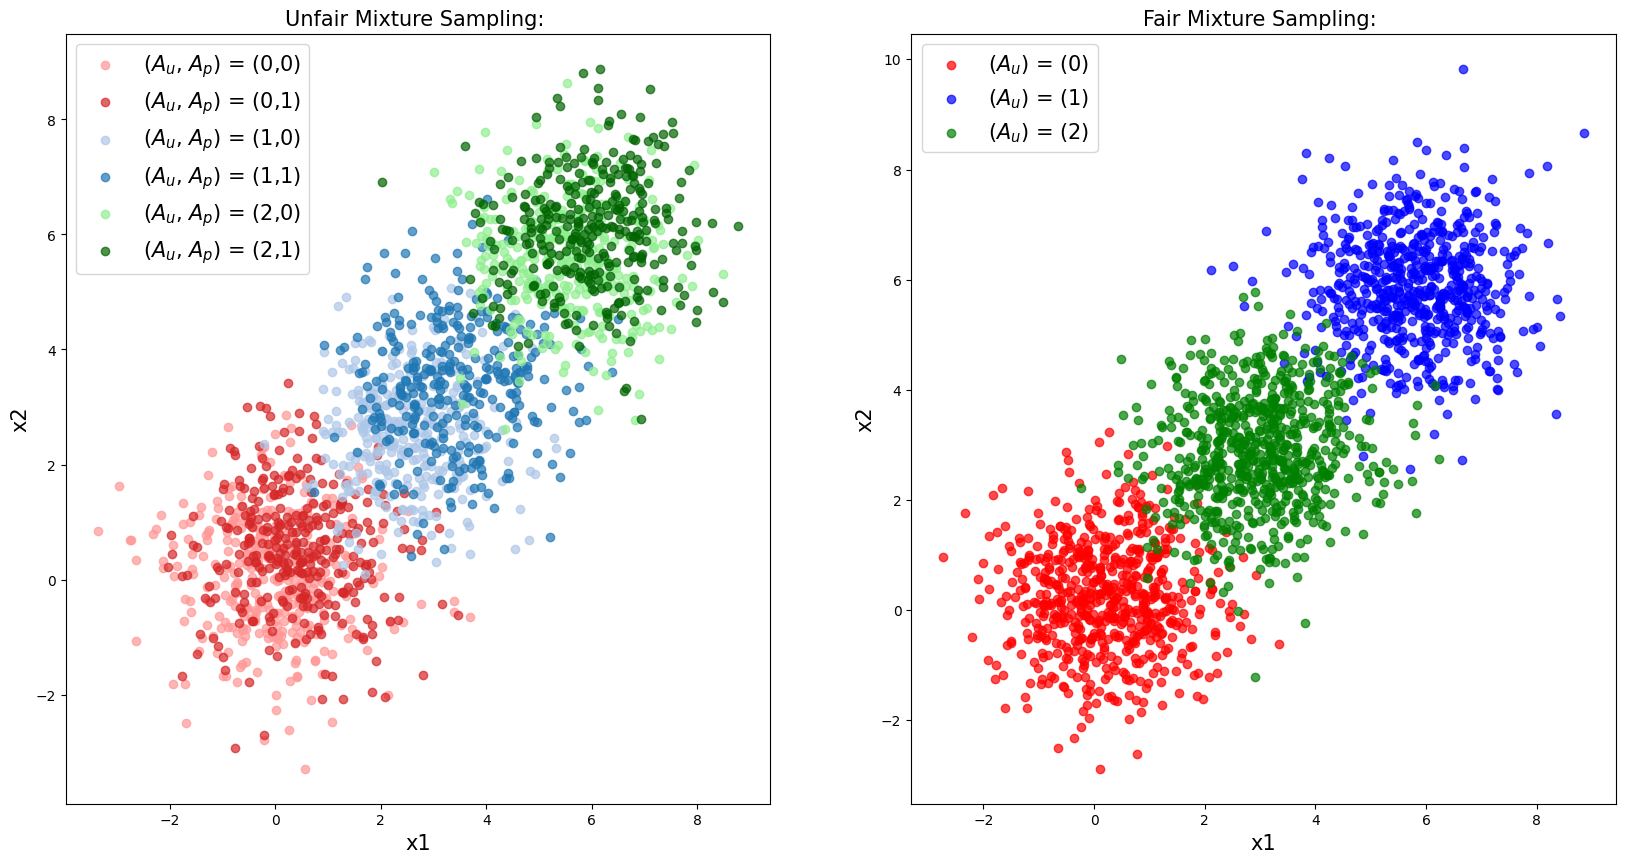

(400, 2)
[0. 1. 2.] [0. 1.] [0. 1. 2.]
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
count 400
0.67
closest pairs  ([0, 1], [2, 3], [4, 5])
weight_m 0.3333333333333333
weight_m2 0.3333333333333333
weight_m3 0.3333333333333333


<Figure size 800x800 with 0 Axes>

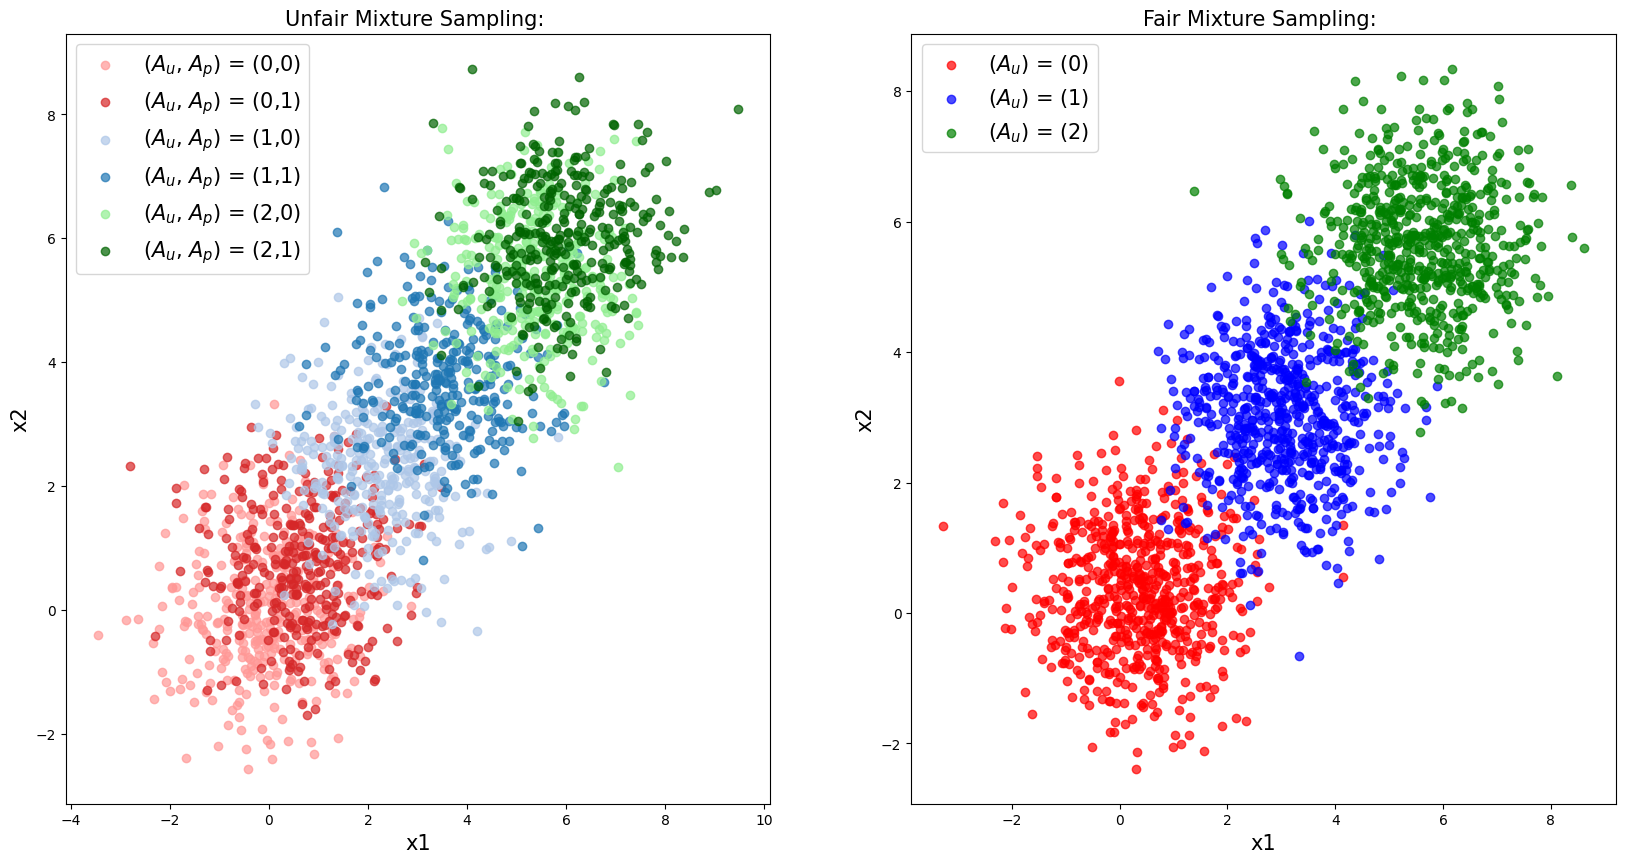

(400, 2)
[0. 1. 2.] [0. 1.] [0. 1. 2.]
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
count 400
0.89
closest pairs  ([0, 1], [2, 3], [4, 5])
weight_m 0.3333333333333333
weight_m2 0.3333333333333333
weight_m3 0.3333333333333333


<Figure size 800x800 with 0 Axes>

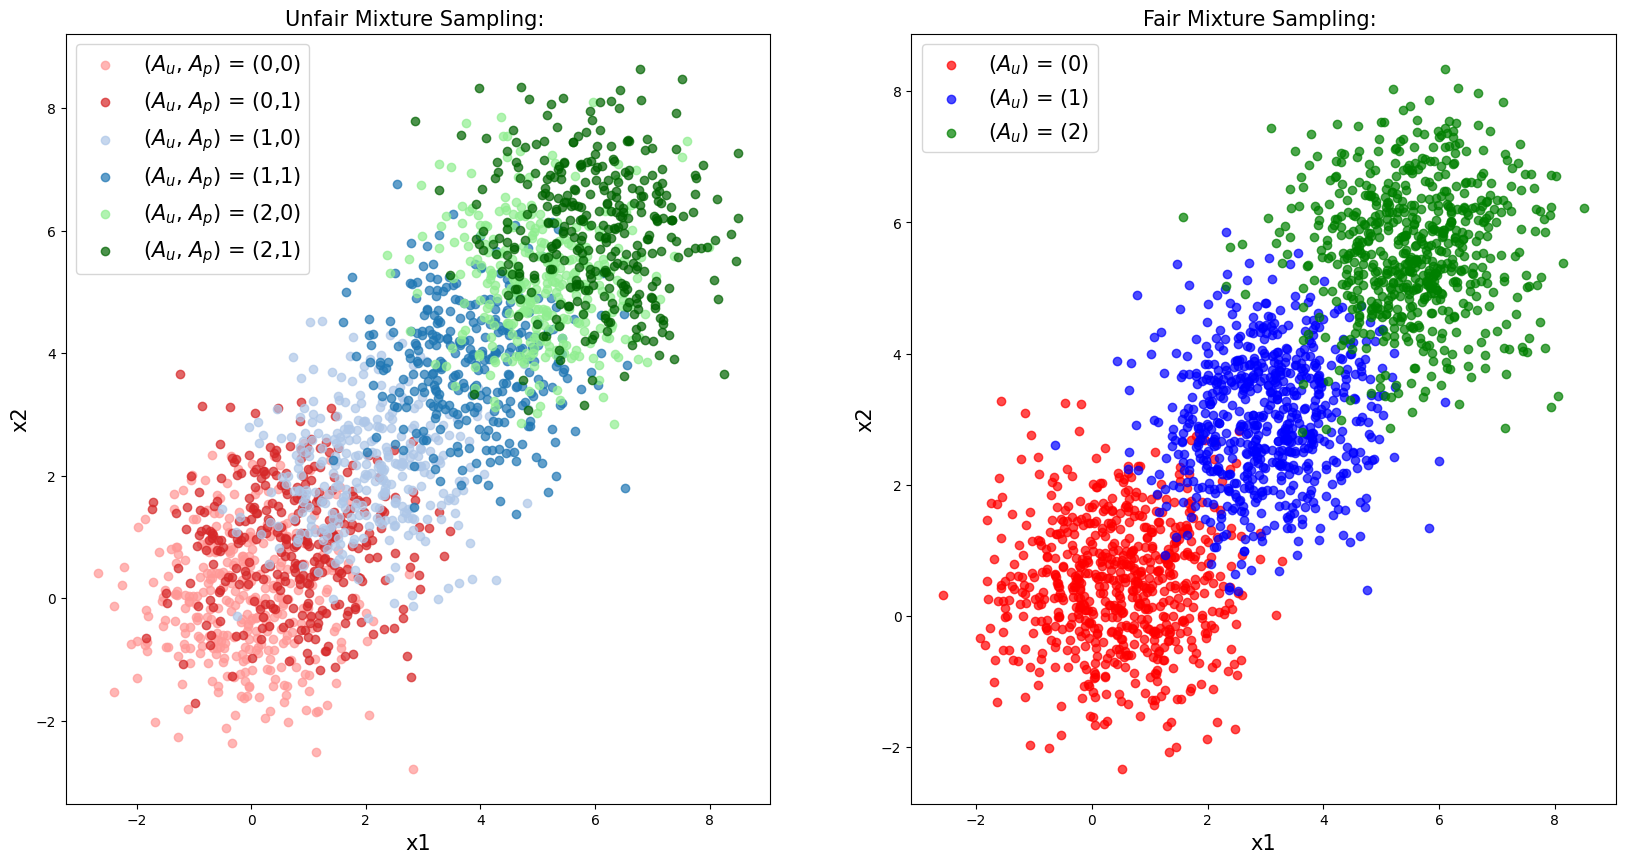

(400, 2)
[0. 1. 2.] [0. 1.] [0. 1. 2.]
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
count 400
1.11
closest pairs  ([0, 1], [2, 3], [4, 5])
weight_m 0.3333333333333333
weight_m2 0.3333333333333333
weight_m3 0.3333333333333333


<Figure size 800x800 with 0 Axes>

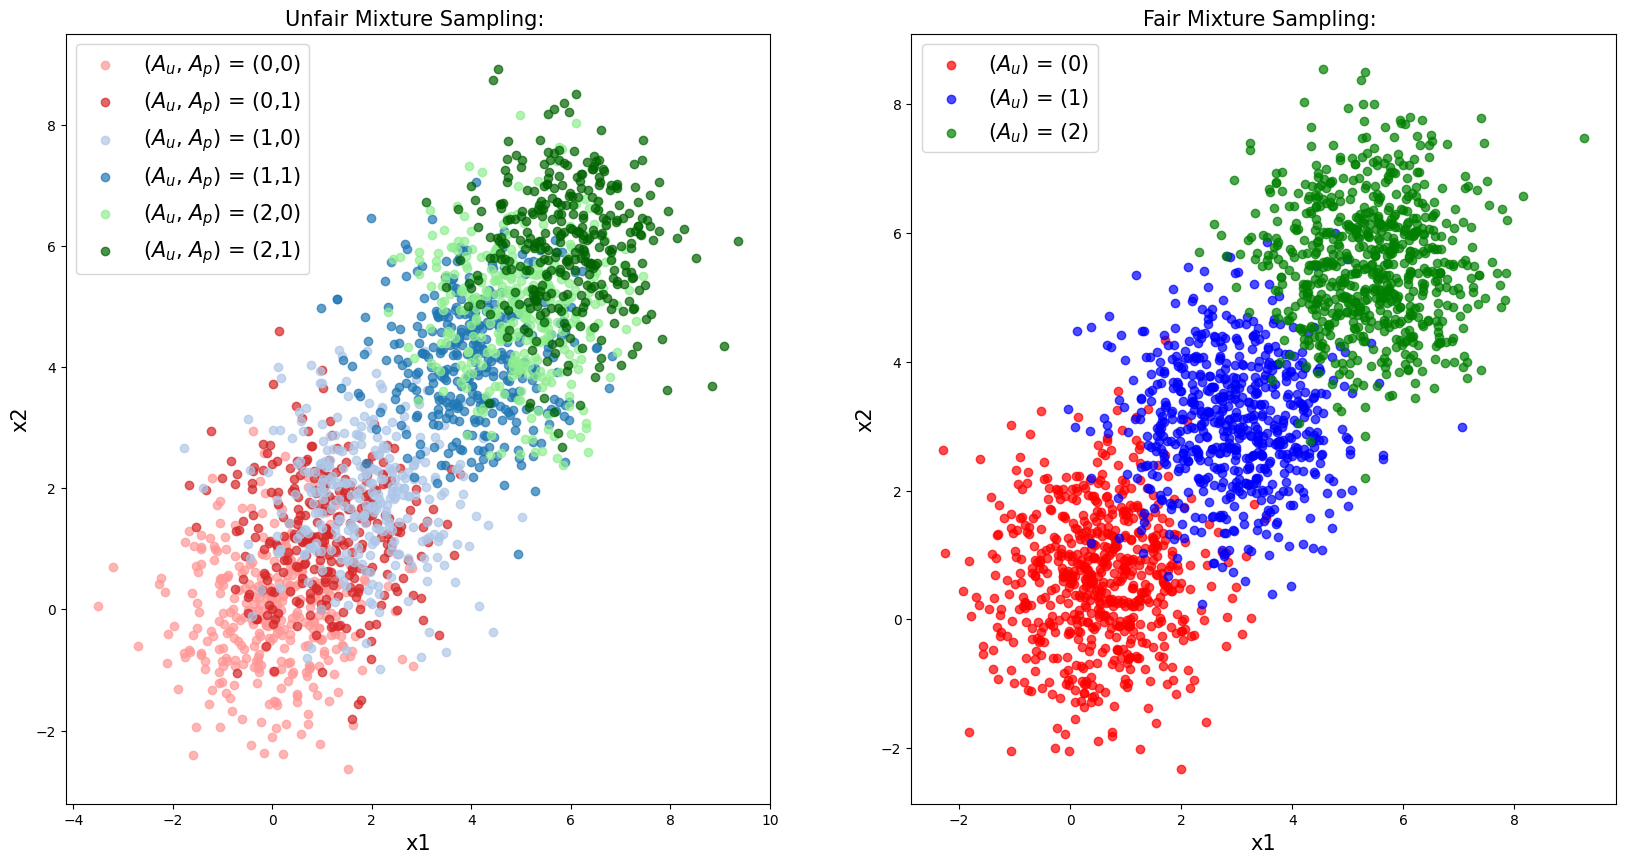

(400, 2)
[0. 1. 2.] [0. 1.] [0. 1. 2.]
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
count 400
1.33
closest pairs  ([0, 1], [2, 3], [4, 5])
weight_m 0.3333333333333333
weight_m2 0.3333333333333333
weight_m3 0.3333333333333333


<Figure size 800x800 with 0 Axes>

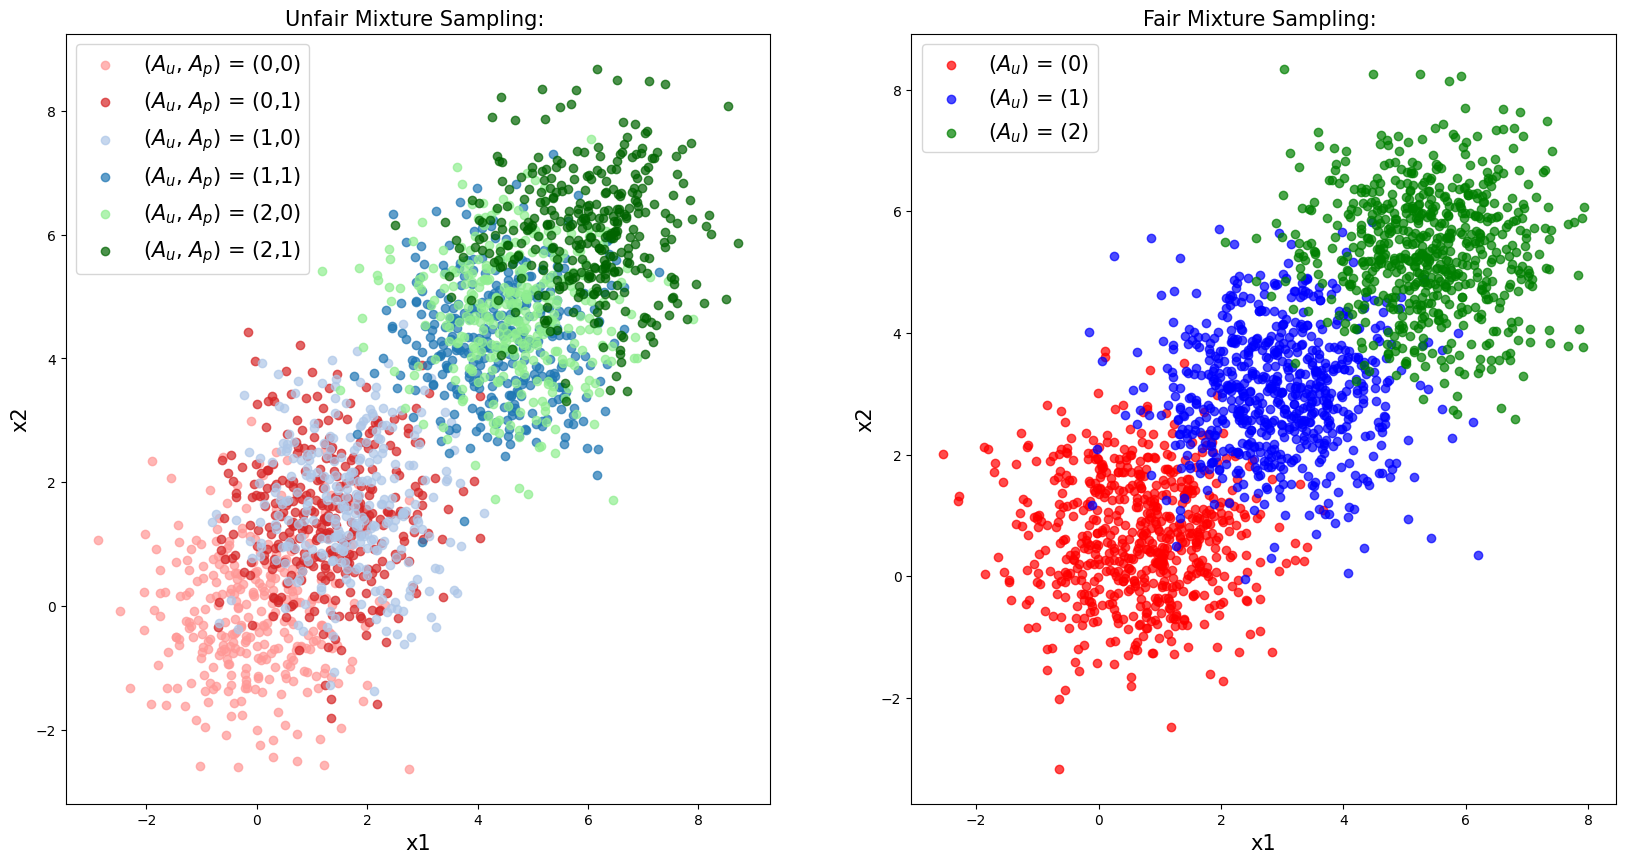

(400, 2)
[0. 1. 2.] [0. 1.] [0. 1. 2.]
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
count 400
1.56
closest pairs  ([0, 2], [1, 4], [3, 5])
weight_m 0.3333333333333333
weight_m2 0.3333333333333333
weight_m3 0.3333333333333333


<Figure size 800x800 with 0 Axes>

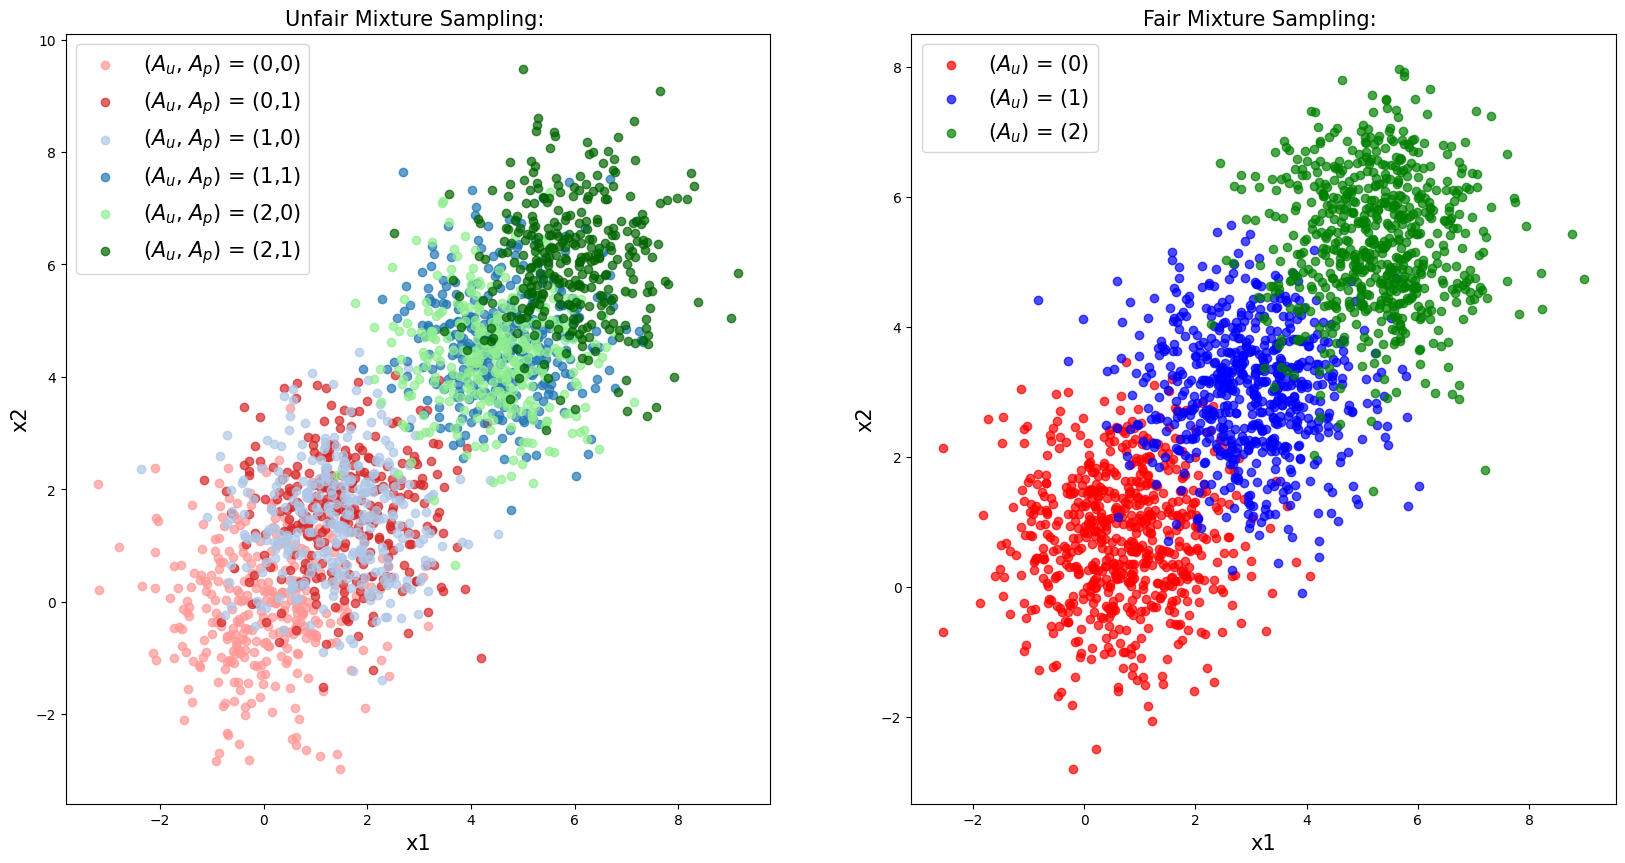

(400, 2)
[0. 1. 2.] [0. 1.] [0. 1. 2.]
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
count 400
1.78
closest pairs  ([0, 2], [1, 4], [3, 5])
weight_m 0.3333333333333333
weight_m2 0.3333333333333333
weight_m3 0.3333333333333333


<Figure size 800x800 with 0 Axes>

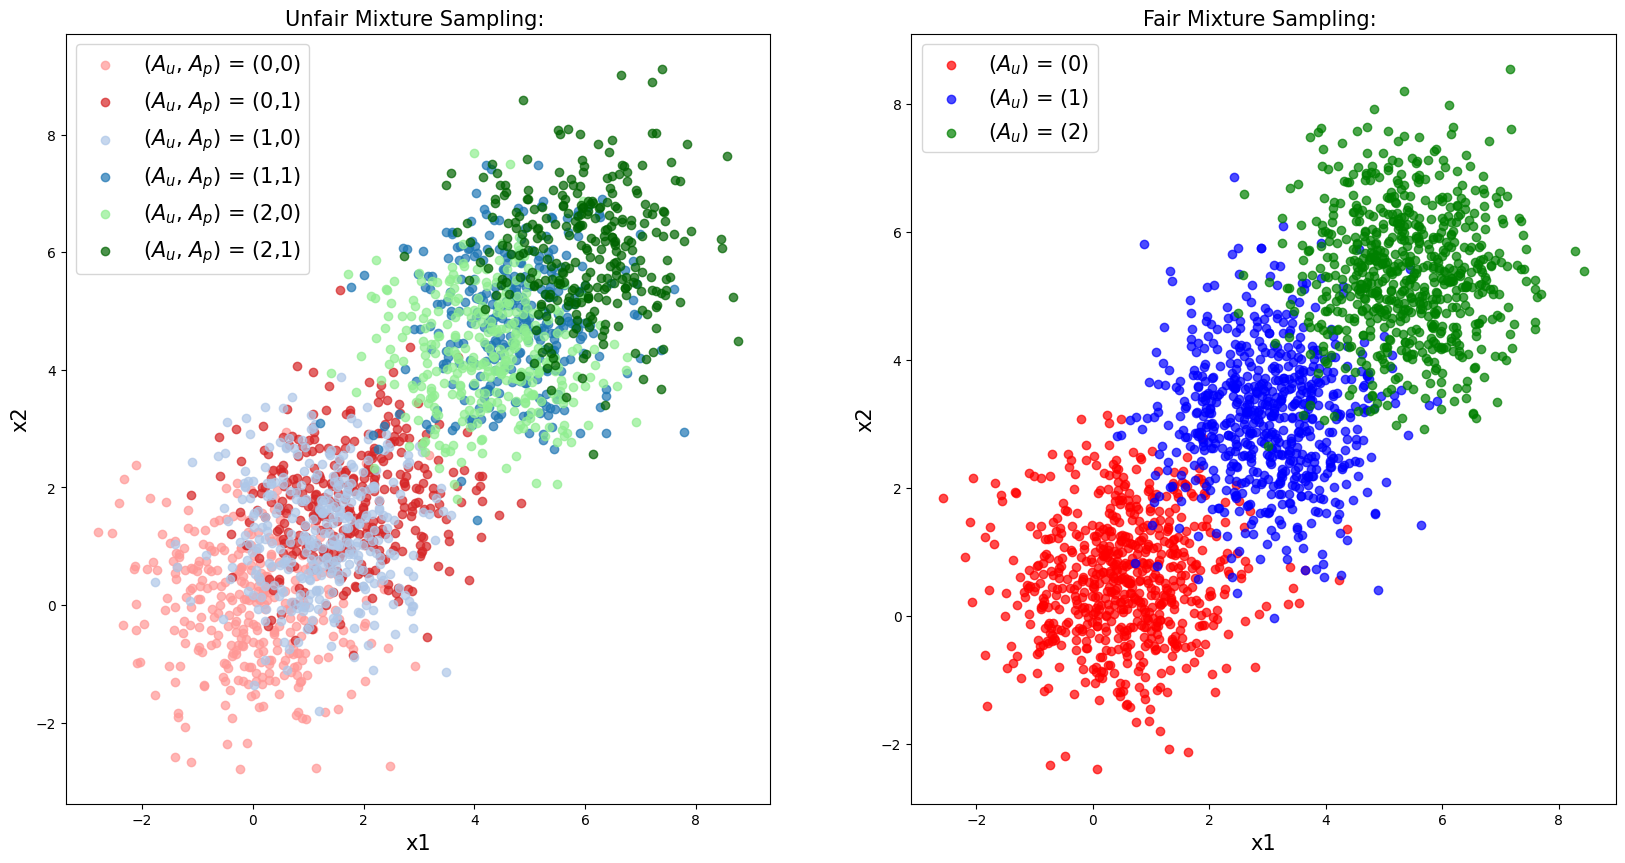

(400, 2)
[0. 1. 2.] [0. 1.] [0. 1. 2.]
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
count 400
2.0
closest pairs  ([0, 2], [1, 4], [3, 5])
weight_m 0.3333333333333333
weight_m2 0.3333333333333333
weight_m3 0.3333333333333333


<Figure size 800x800 with 0 Axes>

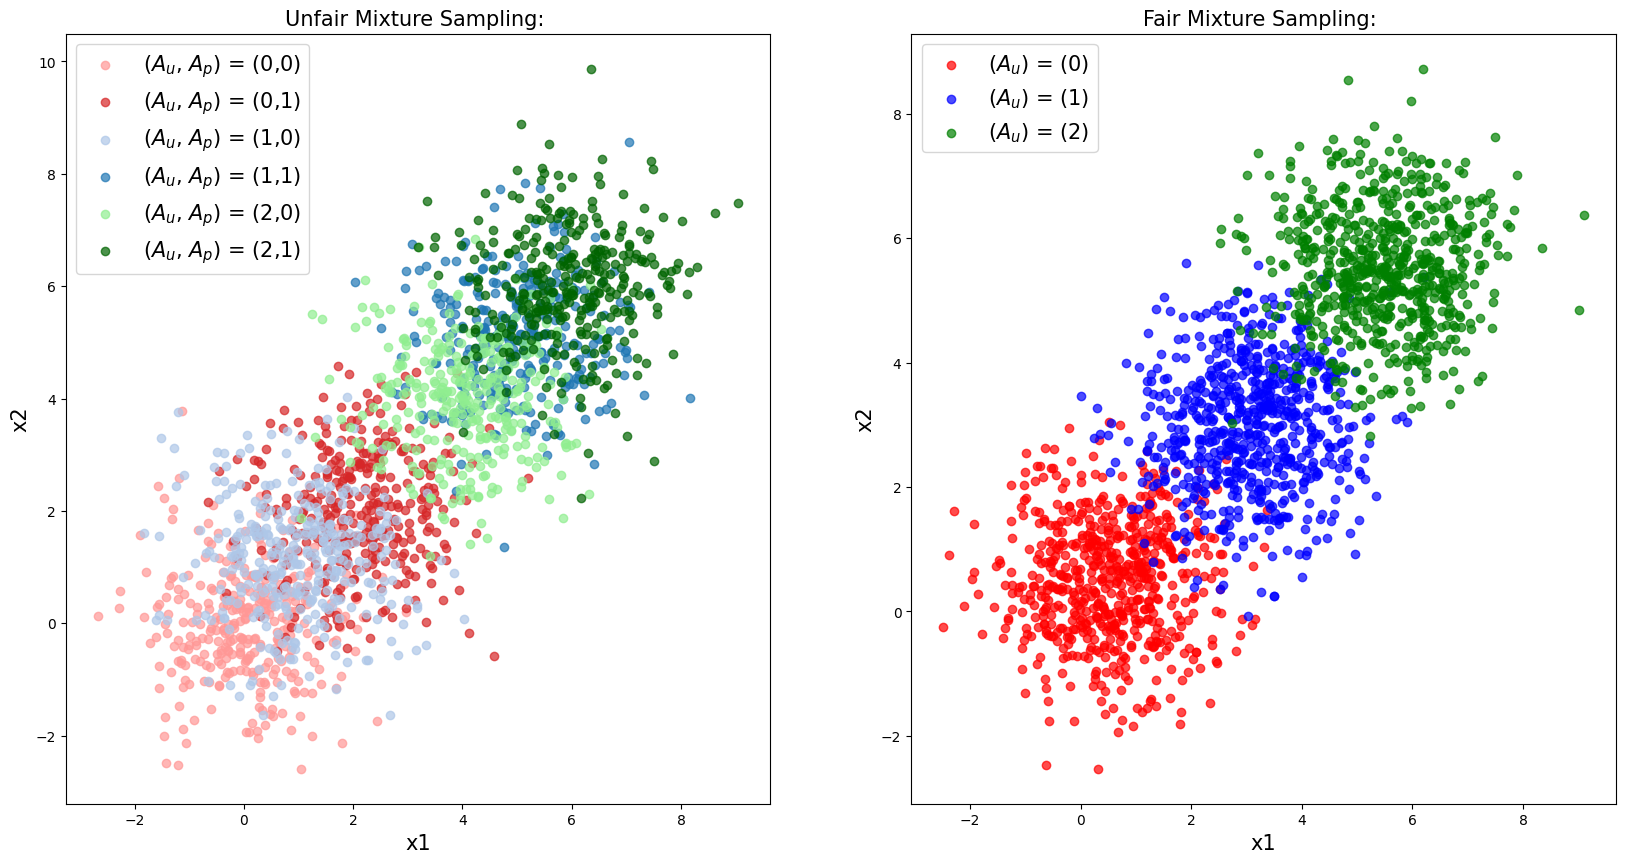

(400, 2)
[0. 1. 2.] [0. 1.] [0. 1. 2.]
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
count 400


<Figure size 800x800 with 0 Axes>

In [298]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import adjusted_rand_score

mu  = [0, 0]#dark red
mu2 = [0, 0]#light red
mu3 = [3, 3]#dark blue
mu4 = [3, 3]#light blue
mu5 = [6, 6]#dark green
mu6 = [6, 6]#light green


cov  = [[1, 0], 
        [0, 1]]
cov2 = [[1, 0],
        [0, 1]]
cov3 = [[1, 0],
        [0, 1]]
cov4 =  [[1, 0],
        [0, 1]]
cov5 =  [[1, 0],
        [0, 1]] 
cov6 =  [[1, 0],
        [0, 1]]



#Pr[Ap ] = 0.6
prob_p = [0.5, 0.5]
#Pr[Au | Ap=0 ]
p_u1  = [ 1/3, 1/3, 1/3]
#Pr[Au | Ap=1 ]
p_u2  = [ 1/3, 1/3, 1/3]	
	

prob = [p_u1[0]*prob_p[0], p_u1[1]*prob_p[0], p_u1[2]*prob_p[0], p_u2[0]*prob_p[1], p_u2[1]*prob_p[1], p_u2[2]*prob_p[1]]
n = 2000
d = 2



mean_range2  = np.linspace(0, 2, 10)
mean_range2 = np.round(mean_range2, 2)
corr_range = np.linspace(-0.9,0.9,10)

eps = 1e-8

KLD_list = []
Dist_list = []
DI_list = []
var_x = 1
var_y = 1

# cov = f_cov(var_x, var_y, -0.9)
# cov2 = f_cov(var_x, var_y, -0.9)
# cov3 = f_cov(var_x, var_y, -0.9)
# cov4 = f_cov(var_x, var_y, -0.9)

for i in range(len(mean_range2)):
        print(mean_range2[i]) 
        
        mu2 = [0+mean_range2[i],0+mean_range2[i]]

        mu3 = [3-mean_range2[i],3-mean_range2[i]]
        mu4 = [3+mean_range2[i],3+mean_range2[i]]

        mu5 = [6-mean_range2[i],6-mean_range2[i]]
        #mu6 = [6-mean_range2[i],6-mean_range2[i]]

        # cov2   = f_cov(var_x, var_y, corr_range[i])
        # cov3 = f_cov(var_x, var_y, corr_range[i])


        dist = np.linalg.norm(np.array(mu) - np.array(mu2))

        # print('mu', mu)
        # print('mu2',mu2)
        # print('mu3',mu3)
        # print('mu4',mu4)
        X_F = sample_guassian_F(mu, mu2, mu3, mu4, mu5, mu6, cov, cov2, cov3, cov4, cov5, cov6, n, prob, d)
        y_A = X_F[2,:]

        X_UF = sample_guassian_UF(mu, mu2, mu3, mu4, mu5, mu6, cov, cov2, cov3, cov4, cov5, cov6, n, prob, d)
        y_Ap= X_UF[3,:]
        y_Au = X_UF[2,:]

        # plot the data
        
        fig = plt.figure(figsize=(20, 10))
        plot_fair_vs_unfair(X_UF, y_Ap, y_Au,  X_F, y_A)
        plt.show()

      

        #fair clustering

        X0 = X_UF[:,y_Ap==0]
        X1 = X_UF[:,y_Ap==1]


        Y0= X0[2:4,:].T
        Y1= X1[2:4,:].T

        X0 = X0[0:2,:].T
        X1 = X1[0:2,:].T
        iter = 10
        N, labels_gmm, y_test = fair_clustering(X_F.T, y_A)

        #unfair clustering
        di, M = unfair_clustering(X_UF.T, y_Au, y_Ap)

        # print (di)
        # print (M)
        # print (N)
        # print (KLD_(M, N, eps))
        KLD_list.append(KLD_(M, N, eps))
        Dist_list.append(dist)
        DI_list.append(di)


    


In [278]:
np.shape(KLD_list)

(10, 6)

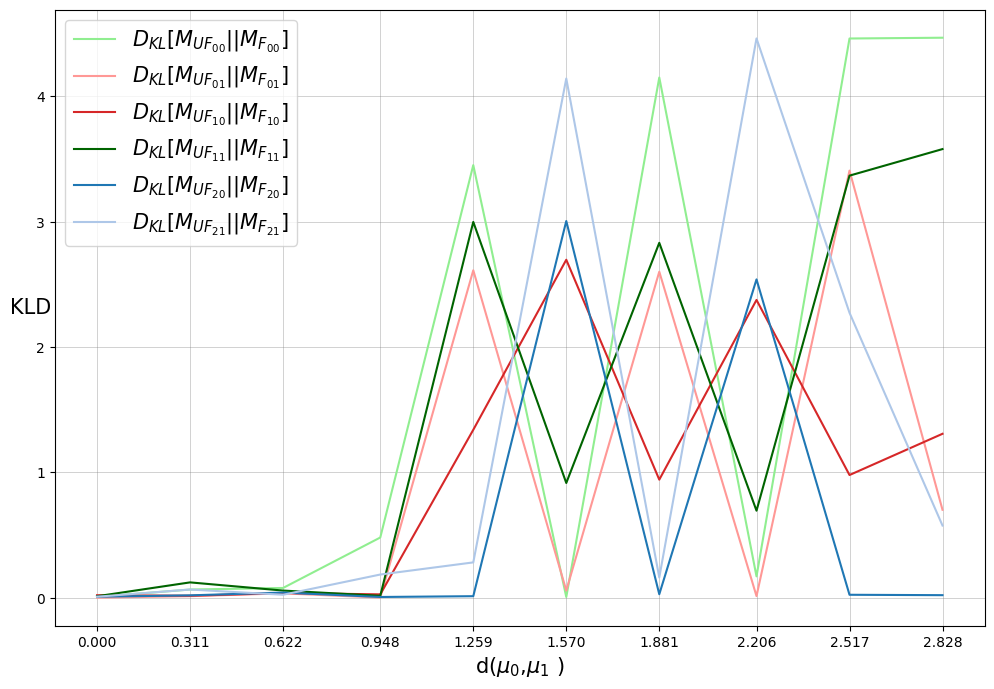

In [295]:
import numpy as np

# Two shades of red
dark_red = '#d62728' # darker red
light_red = '#ff9896' # lighter red

light_green = '#90EE90'
dark_green = '#006400'

# Convert the list to a numpy array
KLD_array = np.array(KLD_list)

# Extract the first column of the array
kl1 = KLD_array[:, 0]
kl2 = KLD_array[:, 1]
kl3 = KLD_array[:, 2]
kl4 = KLD_array[:, 3]
kl5 = KLD_array[:, 4]	
kl6 = KLD_array[:, 5]

# Plot the first column
fig = plt.figure(figsize=(12, 8))
plt.plot(Dist_list, kl1, label=r'$D_{KL}[M_{UF_{00}}||M_{F_{00}}]$', color=light_green )
plt.plot(Dist_list, kl2, label=r'$D_{KL}[M_{UF_{01}}||M_{F_{01}}]$', color=light_red )
plt.plot(Dist_list, kl3, label=r'$D_{KL}[M_{UF_{10}}||M_{F_{10}}]$', color = dark_red)
plt.plot(Dist_list, kl4, label=r'$D_{KL}[M_{UF_{11}}||M_{F_{11}}]$', color = dark_green)
plt.plot(Dist_list, kl5, label=r'$D_{KL}[M_{UF_{20}}||M_{F_{20}}]$', color = dark_blue)
plt.plot(Dist_list, kl6, label=r'$D_{KL}[M_{UF_{21}}||M_{F_{21}}]$', color = light_blue)
plt.xlabel( r'd($\mu_0$,$\mu_1$ )', fontsize = 15)
grid_pos = Dist_list

# draw vertical grid lines at the specified positions
plt.grid(axis='both', color='grey', linewidth=.5, linestyle='-', which='major', alpha=0.5)
plt.gca().set_xticks(grid_pos, minor=False)

plt.legend(fontsize=15)

plt.ylabel('KLD', fontsize = 15,  rotation=0)
plt.show()



In [287]:
KLD_list_DI = np.zeros(len(KLD_list))
for i in range(len(KLD_list)):
        print(i)
        KLD_list_DI[i] = np.sum(KLD_list[i])

0
1
2
3
4
5
6
7
8
9


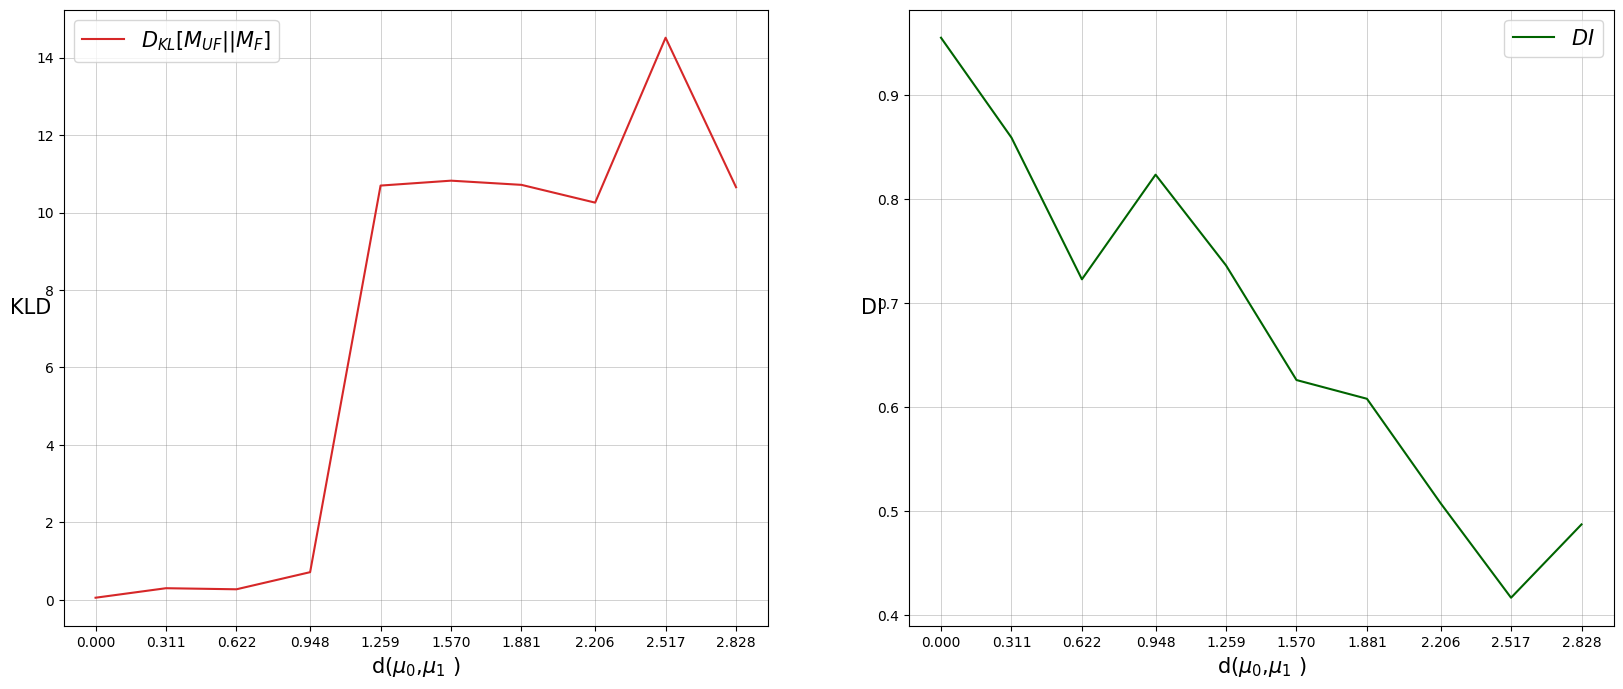

In [294]:
#plot the KLD_list_DI
fig = plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(Dist_list, KLD_list_DI, label=r'$D_{KL}[M_{UF}||M_{F}]$', color=dark_red)
plt.xlabel( r'd($\mu_0$,$\mu_1$ )', fontsize = 15)
grid_pos = Dist_list

# draw vertical grid lines at the specified positions
plt.grid(axis='both', color='grey', linewidth=.5, linestyle='-', which='major', alpha=0.5)
plt.gca().set_xticks(grid_pos, minor=False)

plt.legend(fontsize=15)

plt.ylabel('KLD', fontsize = 15,  rotation=0)

plt.subplot(1, 2, 2)
plt.plot(Dist_list, DI_list, label=r'$DI$', color=dark_green)
plt.xlabel( r'd($\mu_0$,$\mu_1$ )', fontsize = 15)
grid_pos = Dist_list

# draw vertical grid lines at the specified positions
plt.grid(axis='both', color='grey', linewidth=.5, linestyle='-', which='major', alpha=0.5)
plt.gca().set_xticks(grid_pos, minor=False)

plt.legend(fontsize=15)

plt.ylabel('DI', fontsize = 15,  rotation=0)
plt.show()
